# Anomaly Detection (sem Flowmeter)

## Importing the input vectors

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
from ipywidgets import interact
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
testdf = np.load("npy_files/X_input.npy", allow_pickle=True)
X_input = testdf[:,:-2].astype(np.float32)
X_input = np.delete(X_input, np.s_[42:49], axis=1)

anomaly_list = testdf[:,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:,-2]
timestamps = pd.to_datetime(timestamps)

In [30]:
X_input.shape

(4647, 100)

In [31]:
pd.DataFrame(X_input[0,:]).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.984,9.926,-0.012,-0.01,-0.012,-0.012,-0.012,8.562,9.634,9.648,...,303.0,53.0,54.0,302.0,302.0,302.0,302.0,303.0,106.046997,1497.331055


#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [32]:
# Define input dimension
input_dim = X_input.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(256, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(128, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(64, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(16, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(64, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(128, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(256, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

def precision_recall_curve_exclusive(y_true, scores):
    # Get all unique score values as candidate thresholds
    thresholds = np.unique(scores)
    precisions = []
    recalls = []

    for thresh in thresholds:
        # New thresholding rule: exclusive
        y_pred = scores > thresh
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))

    return np.array(recalls), np.array(precisions), thresholds

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [33]:
print(timestamps[0])
print(timestamps[-1])

2022-04-28 12:59:38.859999895
2022-07-28 11:18:45.227999926


In [34]:
print(np.where(timestamps.month == 5)[0][0], np.where(timestamps.month == 6)[0][0], np.where(timestamps.month == 7)[0][0])

125 1653 3173


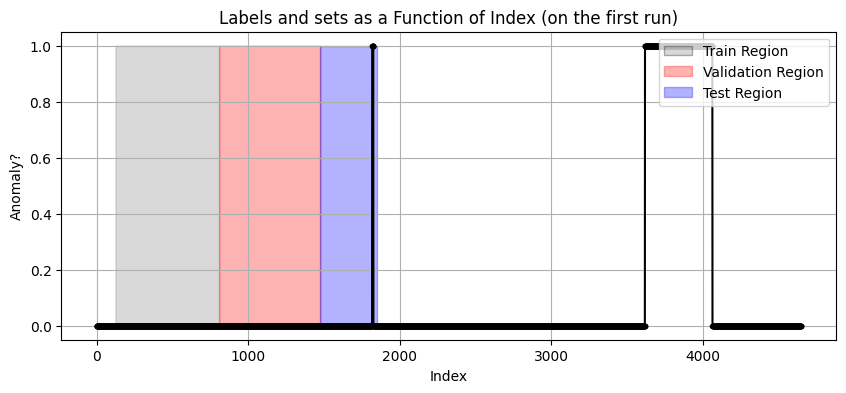

In [35]:
labels_int = [int(label) for label in anomaly_list]

# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
time_delta = 7 # how many days at a time you want to test
index_mai = 125 
index_jun = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=2*time_delta))
index_jul = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jun]+pd.Timedelta(days=2*time_delta))
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=2*time_delta))
'''last_test_index_3 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=3*time_delta))
last_test_index_4 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=4*time_delta))
last_test_index_5 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=5*time_delta))
last_test_index_6 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=6*time_delta))'''
'''last_test_index_7 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=7*time_delta))
last_test_index_8 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=8*time_delta))'''
#last_test_index_9 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=9*time_delta))


# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_mai) & (np.arange(len(anomaly_list)) < index_jun), color='gray', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_jun) & (np.arange(len(anomaly_list)) < index_jul), color='red', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_jul)& (np.arange(len(anomaly_list)) < last_test_index), color='blue', alpha=0.3)
#plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index) & (np.arange(len(anomaly_list)) < last_test_index_2), color='blue', alpha=0.3)
'''plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_2) & (np.arange(len(anomaly_list)) < last_test_index_3), color='blue', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_3) & (np.arange(len(anomaly_list)) < last_test_index_4), color='blue', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_4) & (np.arange(len(anomaly_list)) < last_test_index_5), color='blue', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_5) & (np.arange(len(anomaly_list)) < last_test_index_6), color='blue', alpha=0.3)'''
'''plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_6) & (np.arange(len(anomaly_list)) < last_test_index_7), color='blue', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_7) & (np.arange(len(anomaly_list)) < last_test_index_8), color='blue', alpha=0.3)'''
#plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= last_test_index_8) & (np.arange(len(anomaly_list)) < last_test_index_9), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

#### Boundary condition: the primordial run

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 138.0970 - val_loss: 39.5522
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35.3498 - val_loss: 28.1537
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.7954 - val_loss: 23.7997
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.8880 - val_loss: 20.9618
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.1815 - val_loss: 18.5962
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.0047 - val_loss: 16.6993
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.1789 - val_loss: 15.0527
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.6153 - val_loss: 13.6690
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3081 - val_loss: 12.6428
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.1831 - val_loss: 11.3942
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.1529 - val_loss: 10.4868
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━

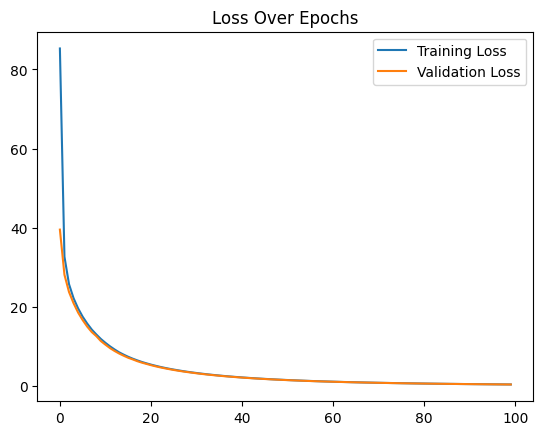

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
k: 3.814521312713623
Threshold:  0.14129147
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  9, 363]))


In [36]:
# Boundary condition: primordial run
# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_input

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []
k_list = []
beta_list = []
batch_limits = []

normal_train_data = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, input_dim), dtype=np.float32)
normal_val_data = np.empty((0, input_dim), dtype=np.float32)
anomalous_val_data = np.empty((0, input_dim), dtype=np.float32)


test_cycle_normalized = np.empty((1, input_dim), dtype=np.float32)
test_cycle = np.empty((1, input_dim), dtype=np.float32)
good_cycles = np.empty((1,input_dim), dtype=np.float32)




# Split the data and labels
train_data = data[index_mai:index_jun].astype(np.float32)
val_data = data[index_jun:index_jul]
val_timestamps = timestamps[index_jun:index_jul].copy()
test_data = data[index_jul:last_test_index].astype(np.float32) # Assuring we only test 1 week at a time
test_timestamps = timestamps[index_jul:last_test_index].copy()
batch_limits.append([index_jul, last_test_index])


train_labels = labels[index_mai:index_jun]
train_len = len(train_labels)
val_labels = labels[index_jun:index_jul]
test_labels = labels[index_jul:last_test_index] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)




normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
'''normal_val_data_normalized = np.zeros_like(normal_val_data)
anomalous_val_data_normalized = np.zeros_like(anomalous_val_data)'''
normal_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)
anomalous_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 3 (columns 14-20)
normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 4 (columns 21-27)
normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 5 (columns 28-34)
normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 35-41)
normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 42-48)
normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 7 (columns 49-55)
normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 8 (columns 56-62)
normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 9
normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 10
normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 11
normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 12
normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 13
normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

'''# Fit and transform sensor 14
normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''


# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

shap_test_data_air = anomalous_val_data_normalized


# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

if timestamps[1818] in val_timestamps:
    shap_test_data_1 = val_data_normalized[np.where(val_timestamps == timestamps[1818])[0][0]:np.where(val_timestamps == timestamps[1818])[0][0]+8].copy()

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized),
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)


Q1_aux = np.percentile(val_loss_normal, 25)
Q3_aux = np.percentile(val_loss_normal, 75)
IQR_aux = Q3_aux - Q1_aux
k_aux = 4
val_threshold = k_aux * IQR_aux + Q3_aux
filtered_val_loss_normal = val_loss_normal[val_loss_normal < val_threshold]

if 1 in val_labels:
    reconstructions_val_anomalous = autoencoder.predict(anomalous_val_data_normalized)
    val_loss_anomalous = tf.keras.losses.mae(reconstructions_val_anomalous, anomalous_val_data_normalized)

    val_mask = (val_loss <= val_threshold) | (val_labels == 1) #Remove "normal" dat beyond a certain threshold

    filtered_val_loss = val_loss[val_mask]
    filtered_val_labels = val_labels[val_mask]

    y_true = (np.array(filtered_val_labels) != 0).astype(int)
    scores = np.array(filtered_val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve_exclusive(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
 ##############################################################REPLACE TYKEY'S FENCES WITH 99-PERCENTILE
    # Compute quartiles and IQR
    Q1 = np.percentile(filtered_val_loss_normal, 25)
    Q3 = np.percentile(filtered_val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    

    plt.hist(val_loss_normal, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(val_loss_anomalous, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Normal')

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right', handles=[
        plt.Line2D([0], [0], color='black', linestyle='--', label='Best Threshold'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Q3')
    ])
    #plt.title(f"Point {n+1}/16. Thr = {best_threshold:.2f}")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.axvline(x=Q3, color='red', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
    
else:
    best_threshold = np.percentile(filtered_val_loss_normal, 100) #REPLACE max(val_loss) by 99-percentile

    # Compute quartiles and IQR
    Q1 = np.percentile(filtered_val_loss_normal, 25)
    Q3 = np.percentile(filtered_val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    print(f"k: {k}")
    #beta = best_threshold/np.percentile(val_loss, 99)

threshold_list.append(best_threshold)
#beta_list.append(beta)
k_list.append(k)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
val_pred = predict(autoencoder, val_data_normalized, best_threshold).numpy()
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
'''pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)'''
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())


#### Plotting the threshold with the test sets

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Max anomaly loss: 0.7478581070899963	 Min anomaly loss: 0.06800541281700134	 Number of anomalous cycles: 8
anomalous test loss: [0.06800541 0.6844375  0.7478131  0.7478581  0.74349153 0.7432186
 0.7261657  0.65218437]


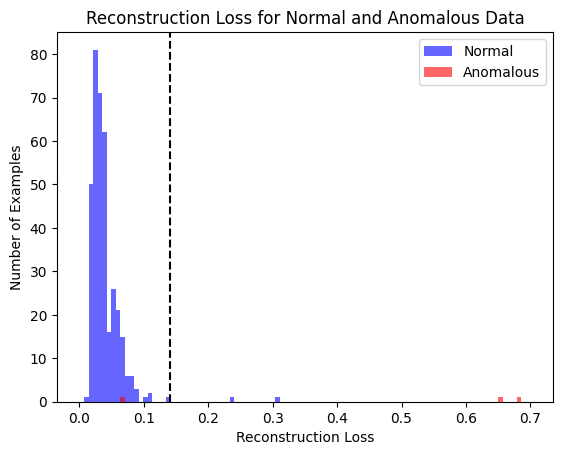

In [37]:
normal_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

try:
    reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
    anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

    # Plot both losses on the same histogram
    plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

    print(f"Max anomaly loss: {np.max(anomalous_test_loss)}\t Min anomaly loss: {np.min(anomalous_test_loss)}\t Number of anomalous cycles: {len(anomalous_test_loss)}" )
    print(f"anomalous test loss: {anomalous_test_loss}")

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right')
    plt.title("Reconstruction Loss for Normal and Anomalous Data")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
except:
    print("No anomalies in the test set")

#### Moving window

Cycle: 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 2/16. k = 3.9298667907714844
Max anomaly loss: 1.1252824068069458	 Min anomaly loss: 0.11550857871770859	 Number of anomalous cycles: 8


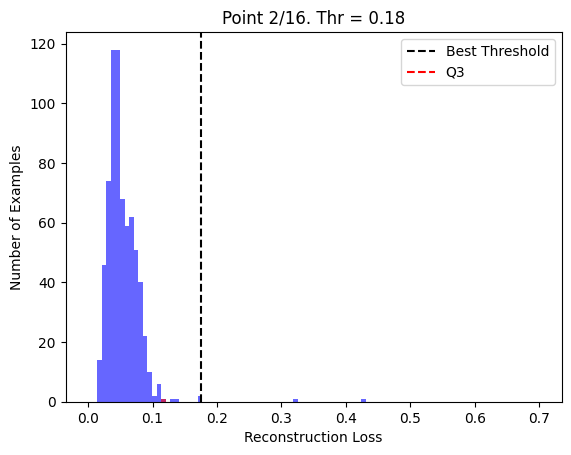

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 323]))
Threshold:  0.17582239
Cycle: 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Point 3/16. k = 3.9343459606170654
Max anomaly loss: 1.1517082452774048	 Min anomaly loss: 0.12089256942272186	 Number of anomalous cycles: 8


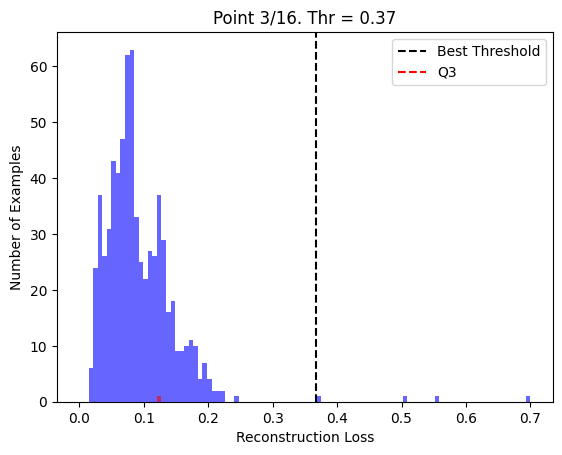

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([355]))
Threshold:  0.36769593
Cycle: 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([ True]), array([402]))
Threshold:  0.36177436
Cycle: 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  2, 325]))
Threshold:  0.37036496
Cycle: 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 306]))
Threshold:  0.38945147
Cycle: 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([282, 331]))
Threshold:  0.36126
Cycle: 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 

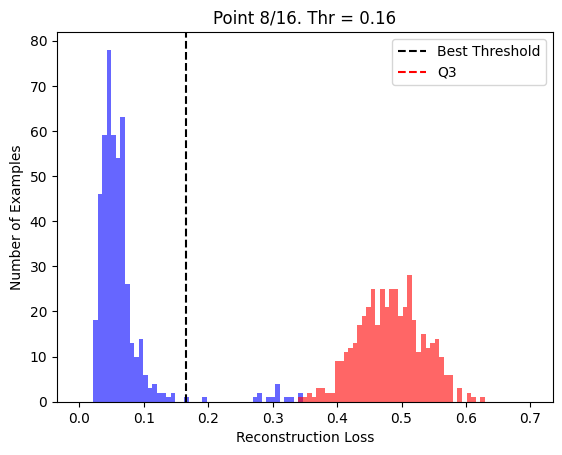

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([282]))
Threshold:  0.1647459
Cycle: 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 9/16. k = 4.066810131072998
Max anomaly loss: 3.3563501834869385	 Min anomaly loss: 0.1323685497045517	 Number of anomalous cycles: 445


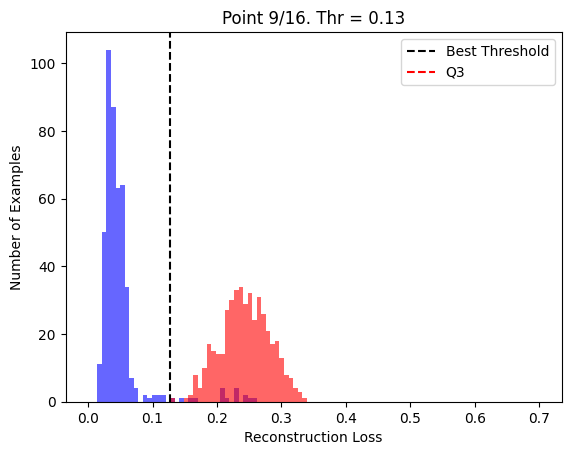

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
pred_aux: (array([False,  True]), array([  2, 186]))
Threshold:  0.1275993


In [38]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(100):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=j*time_delta))
        num_cycles = j+1
    except:
        break


while True:
    try:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jun]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=(n+1)*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:last_test_index_2]
        test_timestamps = timestamps[last_test_index:last_test_index_2].copy()
        test_labels = labels[last_test_index:last_test_index_2]
        batch_limits.append([last_test_index, last_test_index_2])


    except:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jun]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=n*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:]
        test_labels =  labels[last_test_index:]
        batch_limits.append([last_test_index, len(labels)])
        test_timestamps = timestamps[last_test_index:].copy()

        break_flag = True


    val_data = data[first_val_index:last_test_index]
    val_labels = labels[first_val_index:last_test_index]
    val_timestamps = timestamps[first_val_index:last_test_index].copy()

    if 1 in val_labels: #Update training set
        aux_train_indices = [i for i in range(first_val_index) if labels[i] == 0][-train_len:]  # Get the last train_len normal indices
        normal_train_data = data[aux_train_indices]

    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)
    val_data_normalized = np.zeros_like(val_data)
    normal_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)
    anomalous_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 3 (columns 14-20)
    normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 4 (columns 21-27)
    normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 5 (columns 28-34)
    normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 35-41)
    normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 42-48)
    normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 7 (columns 49-55)
    normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 8 (columns 56-62)
    normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 9
    normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 10
    normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 11
    normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 12
    normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 13
    normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    '''# Fit and transform sensor 14
    normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''


    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
    test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
    val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
    test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
    val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()

    '''if n == 1:
        shap_test_data_oil = test_data_normalized
        shap_test_labels_oil = test_labels '''

    if timestamps[3617] in test_timestamps:
        shap_test_data_2 = test_data_normalized[np.where(test_timestamps == timestamps[3617])[0][0]:np.where(test_timestamps == timestamps[3617])[0][0]+445].copy()    

    #Separate into normal and anomalous data
    for i in range(len(val_labels)):
        if val_labels[i] == False:
            normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
        else:
            anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

    if 1 in val_labels:
        reconstructions_val_anomalous = autoencoder.predict(anomalous_val_data_normalized)
        val_loss_anomalous = tf.keras.losses.mae(reconstructions_val_anomalous, anomalous_val_data_normalized)
        # Compile the model with the custom loss
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
        )

        # Train the model
        history = autoencoder.fit(
            x=normal_train_data_normalized,  # Input and target are the same for autoencoders
            y=normal_train_data_normalized,  # Input and target are the same for autoencoders
            epochs=100,
            batch_size=30,
            validation_data=(normal_val_data_normalized, normal_val_data_normalized),
            verbose=0
        )

    ## Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_val = autoencoder.predict(val_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

    reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
    val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)


    Q1_aux = np.percentile(val_loss_normal, 25)
    Q3_aux = np.percentile(val_loss_normal, 75)
    IQR_aux = Q3_aux - Q1_aux
    val_threshold = k_aux * IQR_aux + Q3_aux
    filtered_val_loss_normal = val_loss_normal[val_loss_normal < val_threshold]

    if 1 in val_labels:
        val_mask = (val_loss <= val_threshold) | (val_labels == 1) #Remove "normal" dat beyond a certain threshold

        filtered_val_loss = val_loss[val_mask]
        filtered_val_labels = val_labels[val_mask]

        y_true = (np.array(filtered_val_labels) != 0).astype(int)
        scores = np.array(filtered_val_loss)

        # 1. Calculate precision, recall, and thresholds.
        precision, recall, thresholds = precision_recall_curve_exclusive(y_true, scores)

        # Note: precision and recall arrays have one extra element compared to thresholds.
        # We'll compute F1 scores for the thresholds only.
        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
        # 2. Identify the best threshold (maximizing F1 score)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        # Compute quartiles and IQR
        Q1 = np.percentile(filtered_val_loss_normal, 25)
        Q3 = np.percentile(filtered_val_loss_normal, 75)
        IQR = Q3 - Q1
        # Compute k
        k = (best_threshold - Q3) / IQR

        print(f"Point {n+1}/16. k = {k}")
        print(f"Max anomaly loss: {np.max(val_loss_anomalous)}\t Min anomaly loss: {np.min(val_loss_anomalous)}\t Number of anomalous cycles: {len(val_loss_anomalous)}" )

        plt.hist(val_loss_normal, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
        plt.hist(val_loss_anomalous, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Normal')

        plt.xlabel("Reconstruction Loss")
        plt.ylabel("Number of Examples")
        plt.legend(loc='upper right', handles=[
            plt.Line2D([0], [0], color='black', linestyle='--', label='Best Threshold'),
            plt.Line2D([0], [0], color='red', linestyle='--', label='Q3')
        ])
        plt.title(f"Point {n+1}/16. Thr = {best_threshold:.2f}")
        plt.axvline(x=best_threshold, color='black', linestyle='--')
        #plt.axvline(x=Q3, color='red', linestyle='--')
        #plt.ylim((0, 40))
        plt.show()
        #beta = best_threshold/np.percentile(val_loss, 99)
        

        '''######################################
        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve for Cycle {n+1}/{num_cycles}")
        plt.legend()

        # Plot F1 Score vs. Threshold
        plt.subplot(1, 2, 2)
        plt.plot(thresholds, f1_scores, marker='.', label="F1 Score")
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score vs. Threshold for Cycle {n+1}/{num_cycles}")
        plt.legend()

        plt.tight_layout()
        plt.show()
        ######################################'''
    #Comment out the 'else' if what you want to keep constant is the THRESHOLD and NOT the value of k
    else:
        # Compute quartiles and IQR
        Q1 = np.percentile(filtered_val_loss_normal, 25)
        Q3 = np.percentile(filtered_val_loss_normal, 75)
        IQR = Q3 - Q1
        best_threshold = Q3 + k * IQR
        #best_threshold = beta*np.percentile(val_loss, 99)
    
    k_list.append(k)
    #beta_list.append(beta)
    threshold_list.append(best_threshold)
    
    
    # Calculate the reconstruction loss for the anomalous test data
    pred_val_aux = pred_aux #former test set is now validation set. Use former cycle's test labels as validation labels in this cycle
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy().astype(bool)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)
    print("pred_aux:", np.unique(pred_aux, return_counts=True))
    print("Threshold: ", best_threshold)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break
    n += 1

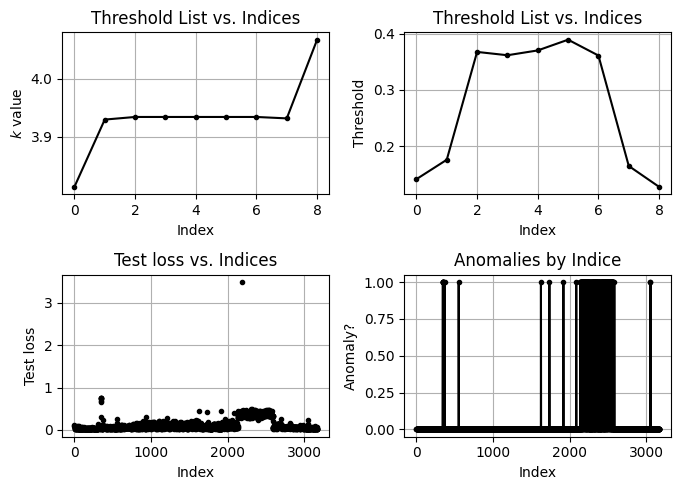

In [39]:
plt.figure(figsize=(7, 5))

# Plot k_list against the respective indices
plt.subplot(2, 2, 1)
plt.plot(k_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('$k$ value')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot threshold_list against the respective indices
plt.subplot(2, 2, 2)
plt.plot(threshold_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot test_loss against the respective indices
plt.subplot(2, 2, 3)
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)

# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.subplot(2, 2, 4)
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)

plt.tight_layout()
plt.show()

## Metrics and Confusion Matrix

Segment 0: start=0, end=372, threshold=0.14129146933555603
Segment 1: start=372, end=696, threshold=0.1758223921060562
Segment 2: start=696, end=1051, threshold=0.3676959276199341
Segment 3: start=1051, end=1453, threshold=0.36177435517311096
Segment 4: start=1453, end=1780, threshold=0.3703649640083313
Segment 5: start=1780, end=2087, threshold=0.3894514739513397
Segment 6: start=2087, end=2700, threshold=0.36125999689102173
Segment 7: start=2700, end=2982, threshold=0.16474589705467224
Segment 8: start=2982, end=3170, threshold=0.12759929895401


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavi

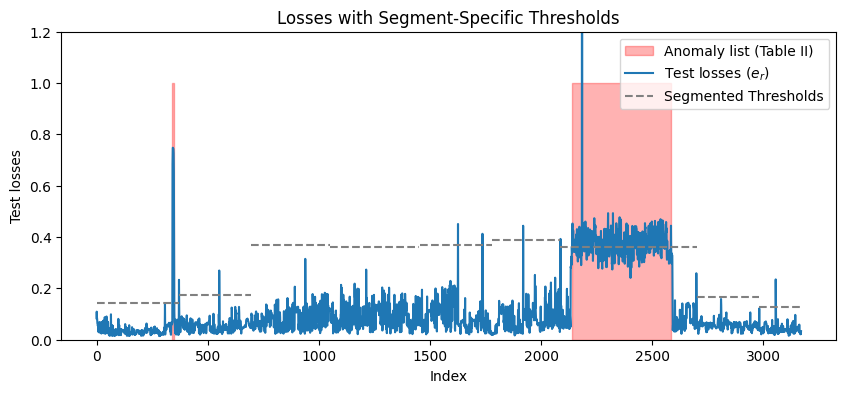

In [40]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
best_predictions_total = []
conf_matrix_list = []
all_predictions = []

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()
aux_index = index_jul
anomaly_list_binary = np.array(anomaly_list[aux_index:], dtype=int)

def compute_f1_for_threshold(anomaly_list_binary, test_loss_normalized, threshold):
    predicted_anomalies = (tf.convert_to_tensor(test_loss_normalized) >= threshold).numpy().astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index
    # Function to compute F1-score for a given threshold
    # Search for the best threshold
    thresholds = np.linspace(0, 1, 10000)
    best_threshold = threshold_list[i]
    best_f1, best_predictions = compute_f1_for_threshold(anomaly_list_binary[start_idx:end_idx], test_loss[start_idx:end_idx], best_threshold)
    best_predictions_total.extend(best_predictions)
    # Compute confusion matrix
    all_predictions = np.concatenate([all_predictions, best_predictions])
    conf_matrix_list.append(confusion_matrix(anomaly_list_binary[start_idx:end_idx], best_predictions, labels=[0, 1]))


# Plot test losses
#aux_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul])
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, 
                 color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.plot(test_loss, label="Test losses ($e_r$)", linestyle='-')

# Plot segmented threshold lines
for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index

    print(f"Segment {i}: start={start_idx}, end={end_idx}, threshold={threshold_list[i]}")
    
    # Ensure non-overlapping segments
    if start_idx < end_idx:
        plt.plot(range(start_idx, end_idx), 
                 threshold_list[i]*np.ones(end_idx - start_idx), 
                 linestyle='--', color='gray')

# Add legend for threshold
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label="Segmented Thresholds")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')

# Formatting
plt.title('Losses with Segment-Specific Thresholds')
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.ylim((0, 1.2))
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |

In [41]:
cm = np.sum(conf_matrix_list, axis=0)
TN, FP, FN, TP = cm.ravel()

# Computing metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP / (TP + FP)) if (TP + FP) > 0 else 0
recall = (TP / (TP + FN)) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

# Display results
print("Confusion Matrix with custom thresholds:")
print(f"{cm}\n")

print(f"Accuracy = {100*accuracy:.2f}%")
print(f"Precision = {100*precision:.2f}%")
print(f"Recall = {100*recall:.2f}%")
print(f"F1 Score = {100*f1_score:.2f}%")

Confusion Matrix with custom thresholds:
[[2707   10]
 [ 166  287]]

Accuracy = 94.45%
Precision = 96.63%
Recall = 63.36%
F1 Score = 76.53%


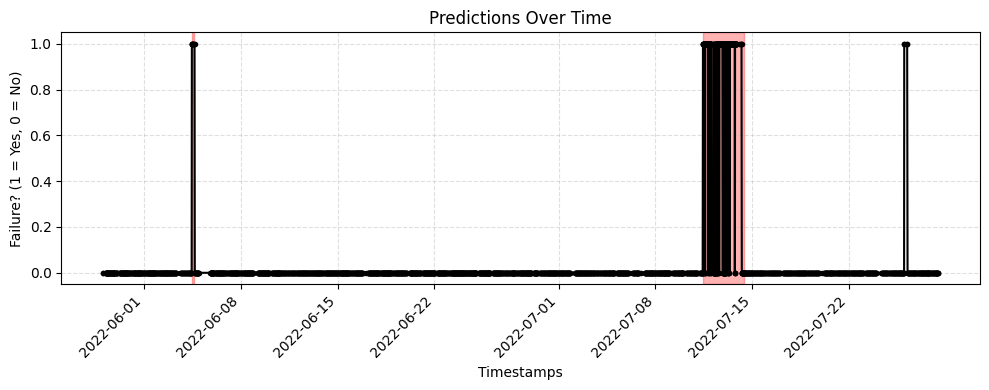

In [42]:
plt.figure(figsize=(10, 4))

# Convert boolean values: True -> 1, False -> 0 for plotting
plot_predictions = [1 if pred else 0 for pred in all_predictions]


def generate_failure_flags(predictions):
    failure_flags = [0] * len(predictions)
    in_failure = False
    i = 0
    while i < len(predictions) - 1:
        if not in_failure:
            # Check for two consecutive anomalies to start a failure
            if predictions[i] == 1 and predictions[i+1] == 1:
                in_failure = True
                failure_flags[i] = 1
                failure_flags[i+1] = 1
                i += 2
                continue
        else:
            failure_flags[i] = 1
            # Check for two consecutive normals to end a failure
            if predictions[i] == 0 and predictions[i+1] == 0:
                in_failure = False
            failure_flags[i+1] = 1
        i += 1

    # Edge case: if in_failure was still True at the end, fill last value
    if in_failure and i == len(predictions) - 1:
        failure_flags[-1] = 1

    return failure_flags

failure_predictions = generate_failure_flags(plot_predictions)




# Plot predictions against timestamps
plt.plot(timestamps[index_jul:], failure_predictions, marker='.', linestyle='-', color='black')

highlight_ranges = [
    ("2022-06-04 10:19:24", "2022-06-04 14:22:39"),
    ("2022-07-11 10:10:1", "2022-07-14 10:22:08.046")
]

for start, end in highlight_ranges:
    plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='red', alpha=0.3)

# Formatting
plt.xlabel('Timestamps')
plt.ylabel('Failure? (1 = Yes, 0 = No)')
plt.title('Predictions Over Time')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
#plt.xlim(pd.Timestamp("2020-04"), pd.Timestamp("2020-08"))
#plt.xlim(pd.Timestamp("2020-07-15"), pd.Timestamp("2020-08"))
#plt.savefig('plot.png', transparent=True)
plt.show()



Confusion Matrix with custom thresholds:
[[783 246]
 [  0 445]]

Accuracy = 83.31%
Precision = 64.40%
Recall = 100.00%
F1 Score = 78.35%

# Explainability

## Root cause analysis - SHAP values

### Anomalous data

In [23]:
import shap

# Wrapper: SHAP expects NumPy, so we convert inputs
def reconstruction_mse(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    recon = autoencoder(x_tensor)
    loss = tf.reduce_mean(tf.math.squared_difference(x_tensor, recon), axis=1)  # shape: (n_samples,)
    return loss.numpy()

def aggregate_sensor_shap(shap_vals):
    shap_sensor = np.zeros((shap_vals.shape[0], 14))
    for i in range(14):
        start = i * 7
        end = start + 7
        shap_sensor[:, i] = np.sum(np.abs(shap_vals[:, start:end]), axis=1)  # abs to get magnitude
    return shap_sensor

In [24]:
X_train_sample = normal_train_data_normalized[-100:]

# Compute reconstruction losses for the test set
reconstructions_shap_test = autoencoder.predict(shap_test_data_oil)
reconstruction_losses = tf.keras.losses.mae(reconstructions_shap_test, shap_test_data_oil).numpy()

# Get indices sorted by loss (descending order)
sorted_indices = np.argsort(reconstruction_losses)[::-1]

# Reorder test_data_normalized and test_labels by sorted_indices
sorted_test_data = shap_test_data_oil[sorted_indices]
sorted_test_labels = shap_test_labels_oil[sorted_indices]

# Select top 10 samples where test_label == 1 (anomaly)
top_anomalous_samples = []
count = 0
for i in range(len(sorted_test_labels)):
    if sorted_test_labels[i] == 1:
        top_anomalous_samples.append(sorted_test_data[i])
        count += 1
        if count == 10:
            break

X_test = np.array(top_anomalous_samples)
X_test.shape  # (10, input_dim)

NameError: name 'shap_test_data_oil' is not defined

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

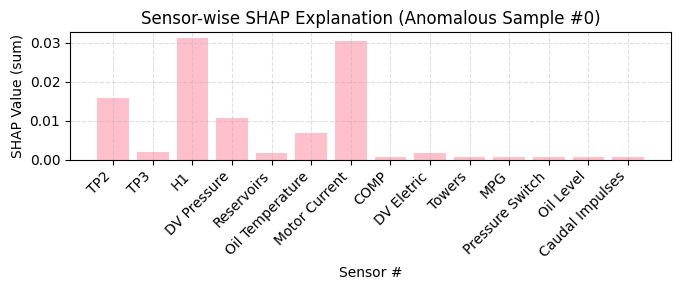

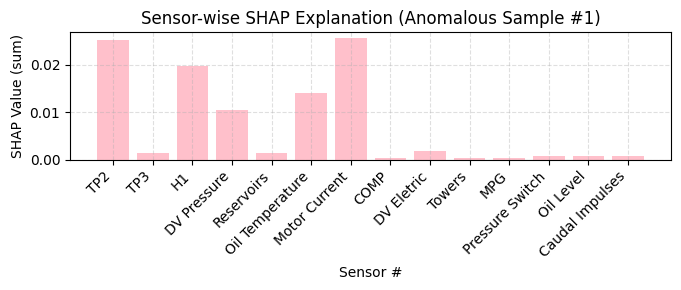

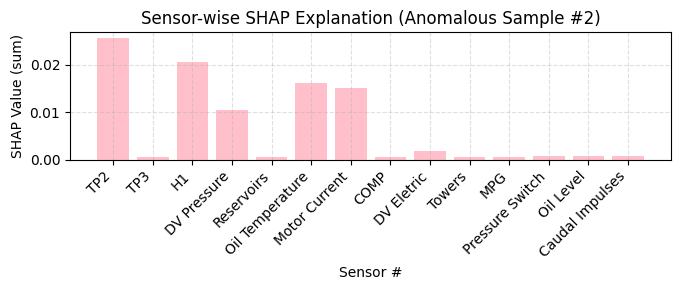

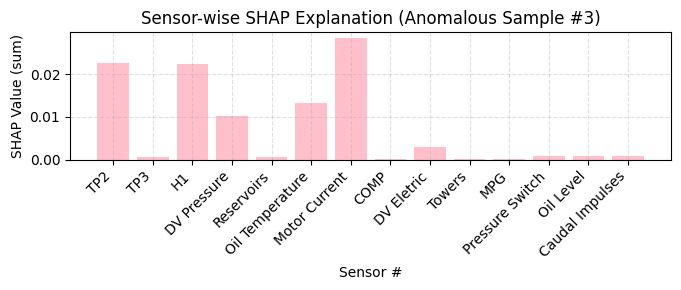

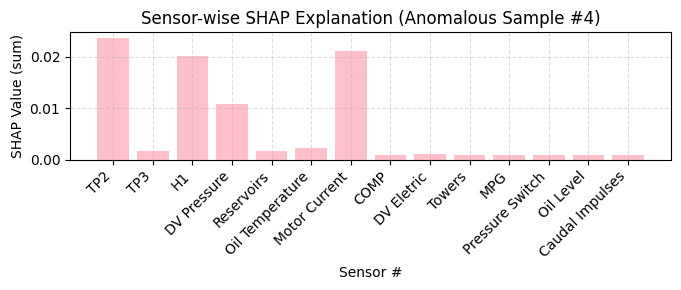

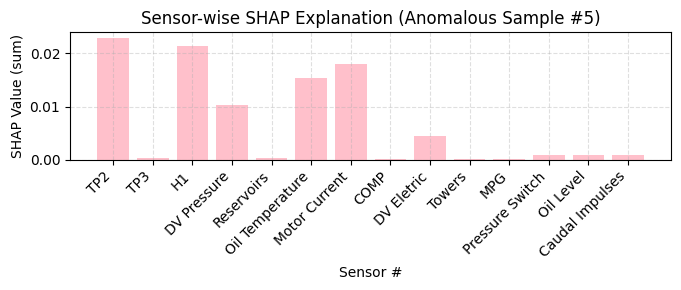

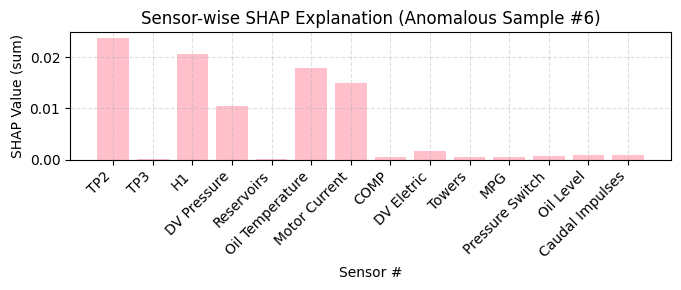

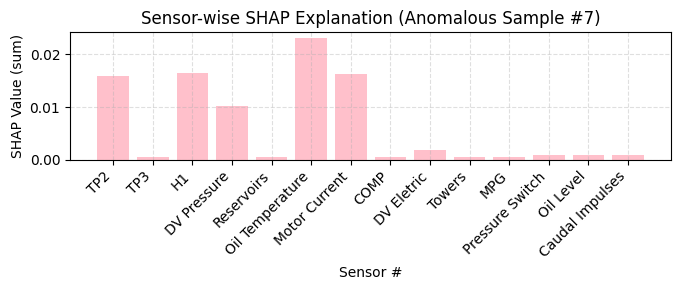

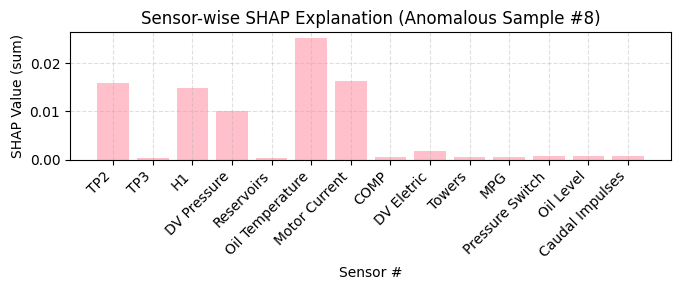

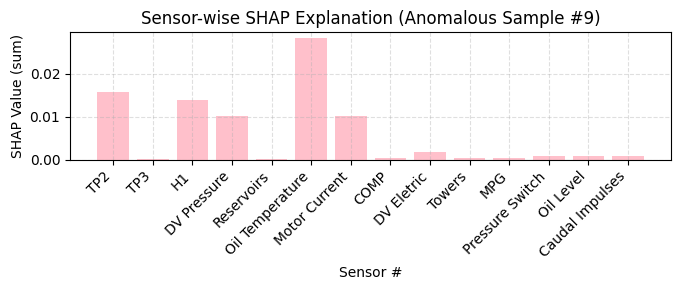

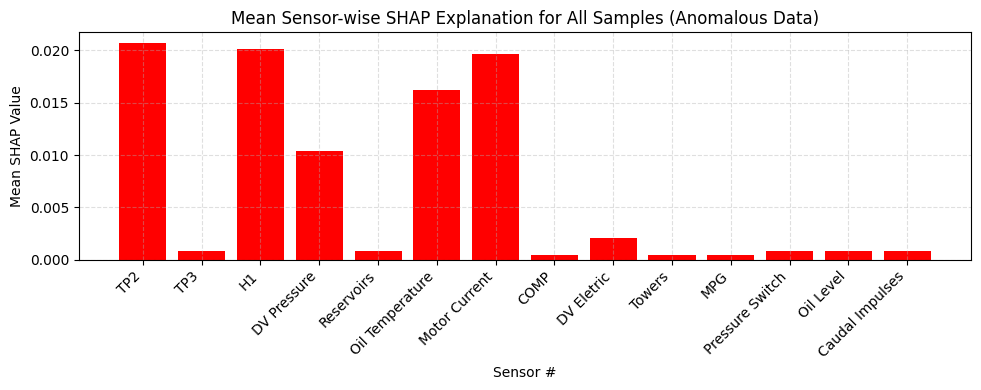

In [ ]:
def plot_sensor_shap_values(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals, color='pink')
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Anomalous Sample #{sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for All Samples (Anomalous Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Normal data

In [ ]:
X_train_sample = normal_train_data_normalized[-100:]

X_test = X_train_sample[np.random.choice(len(X_train_sample), size=10, replace=False)]

X_test = np.array(X_test)
X_test.shape  # (10, input_dim)

(10, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

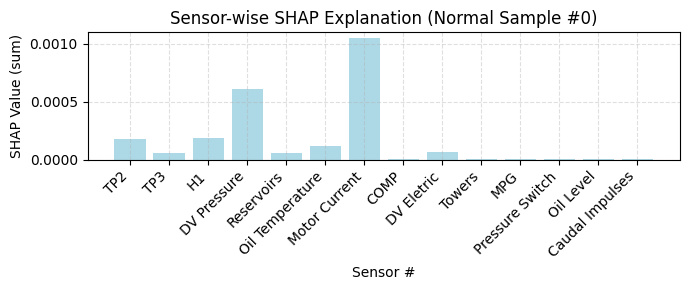

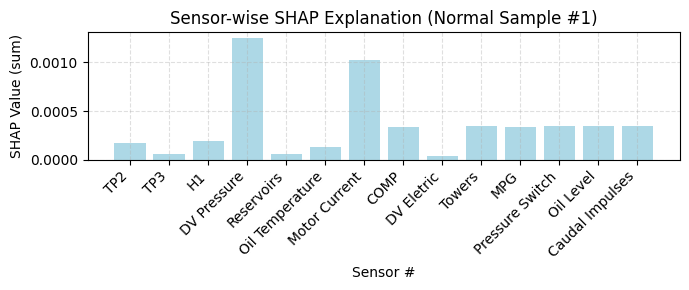

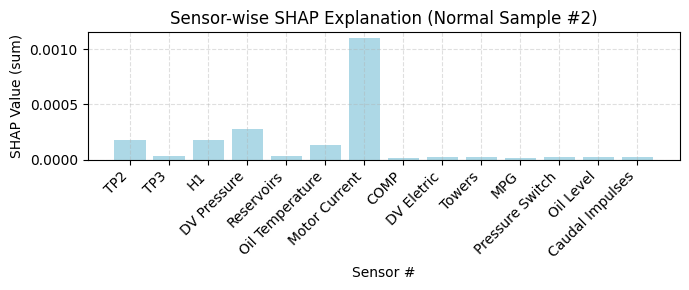

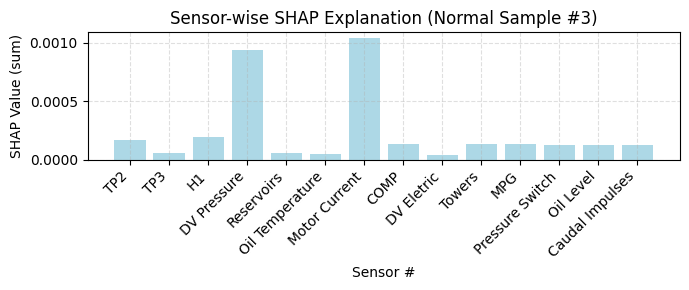

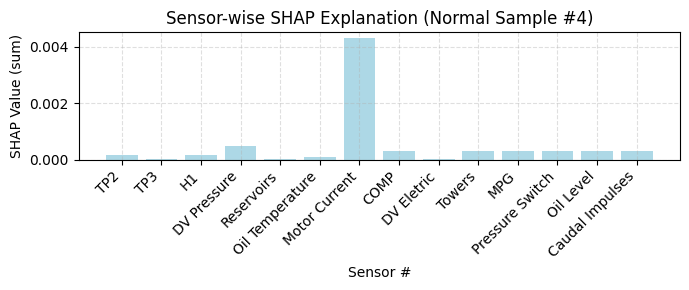

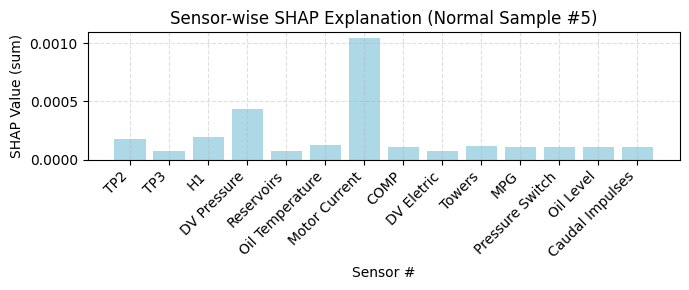

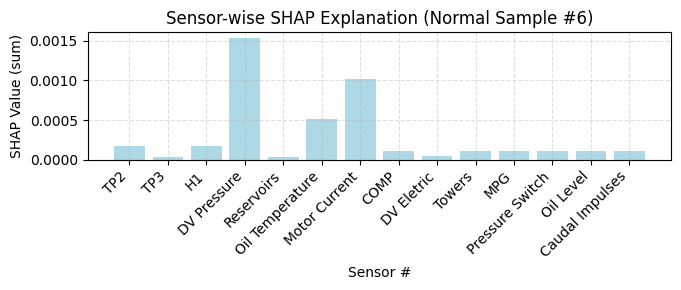

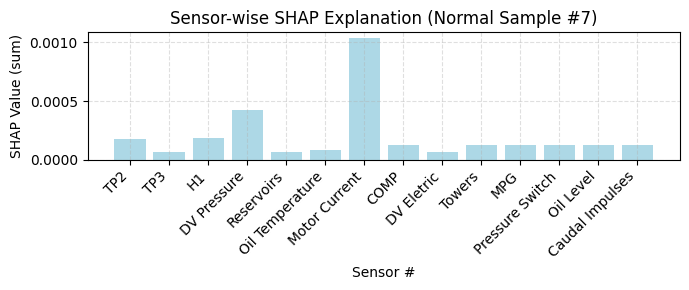

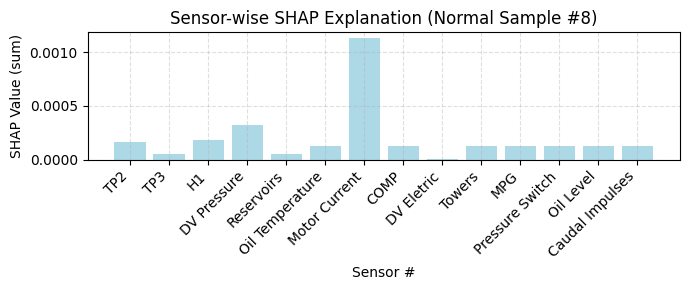

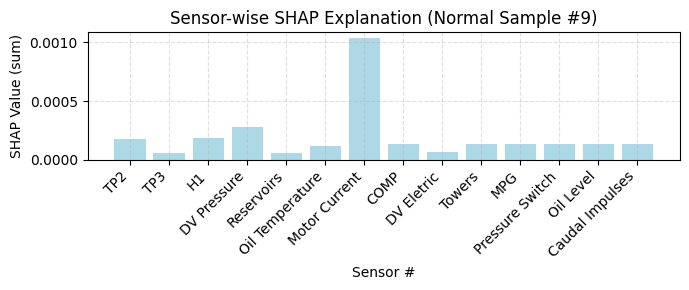

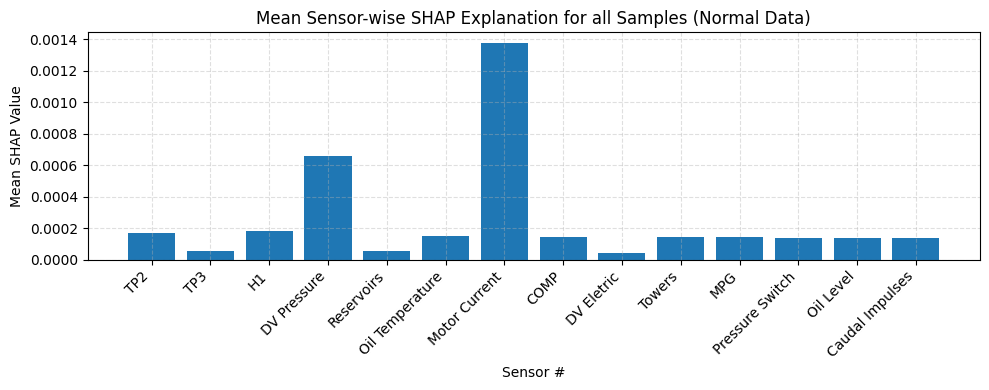

In [ ]:
def plot_sensor_shap_values_normal(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals, color='lightblue')
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Normal Sample #{sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals)
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Pinpointing Sensors

### Normal Background Data

In [ ]:
normal_train_data_normalized.shape

(1528, 100)

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = X_train_sample[np.random.choice(len(X_train_sample), size=150, replace=False)]

X_test = np.array(X_test)
X_test.shape  # (10, input_dim)

(150, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

PermutationExplainer explainer: 151it [00:24,  3.68it/s]                         


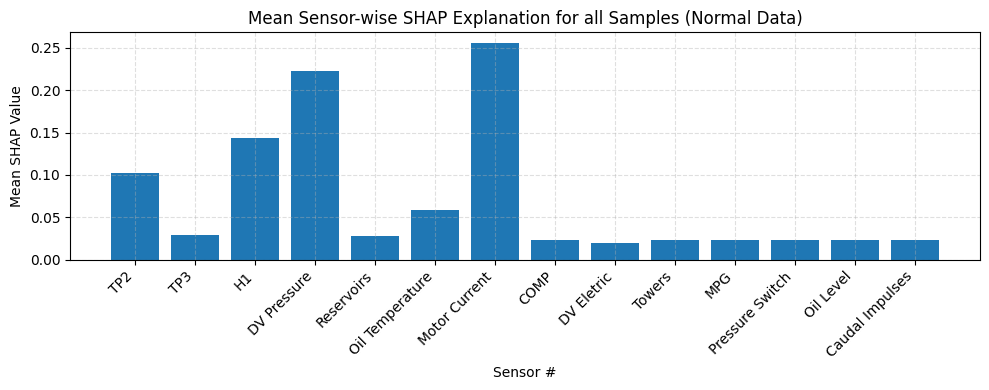

In [ ]:
def plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)
mean_vals_normalized = mean_vals/sum(mean_vals)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_normalized)
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Anomalies

#### Oil

In [ ]:
np.unique(shap_test_labels_oil, return_counts=True)

(array([0, 1], dtype=object), array([185, 445]))

In [ ]:
np.where(shap_test_labels_oil==1)[0][0]

np.int64(153)

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = np.array(shap_test_data_oil[np.where(shap_test_labels_oil==1)[0][0]:np.where(shap_test_labels_oil==1)[0][0]+1])
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


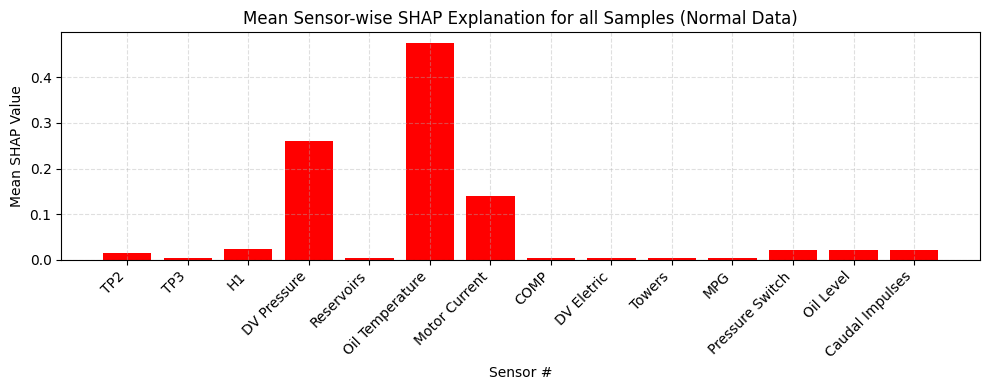

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

##### Comparing anomalous behaviour with normal behaviour

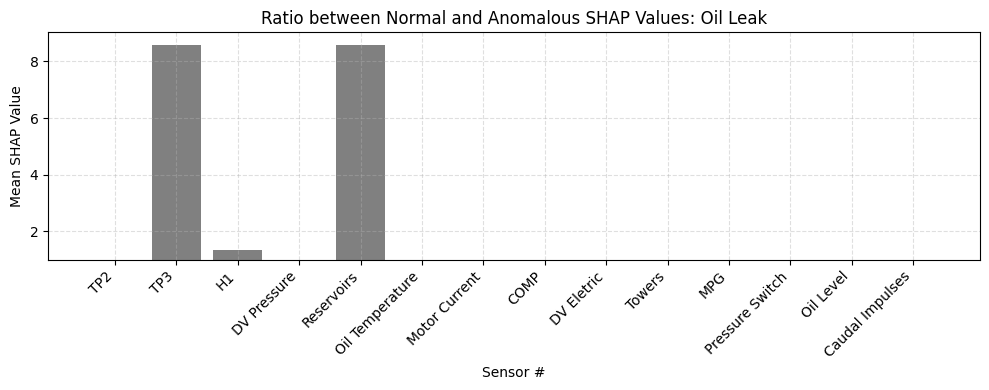

In [ ]:

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), (mean_vals_anomaly_normalized/mean_vals_normalized), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Oil Leak')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()

#### Air

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = shap_test_data_air[0:1]
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


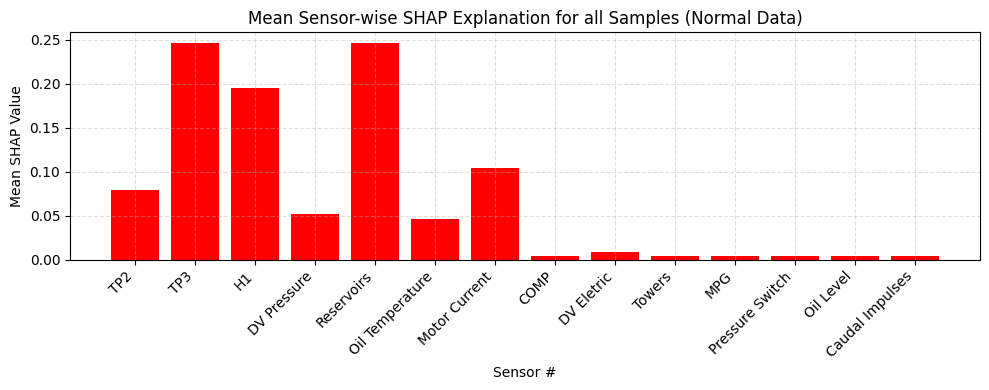

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

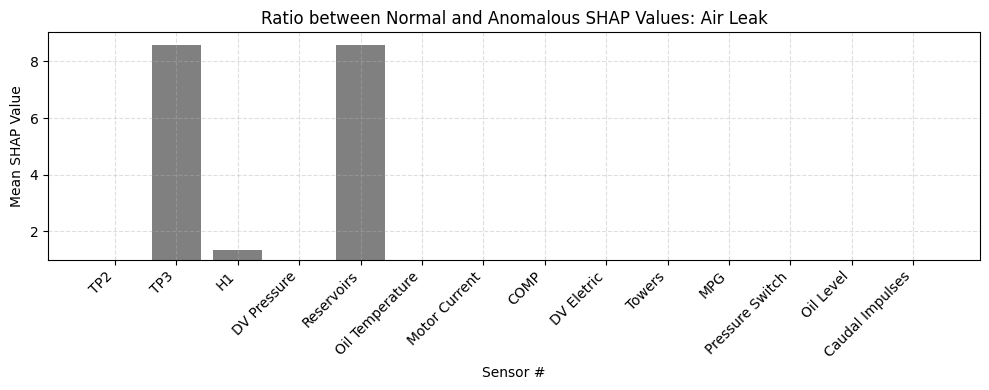

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), (mean_vals_anomaly_normalized/mean_vals_normalized), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Air Leak')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly_air.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()

## Pinpointing Sensors 2.0

In [ ]:
def plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

In [ ]:
# Wrapper: SHAP expects NumPy, so we convert inputs
def reconstruction_mse(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    recon = autoencoder(x_tensor)
    loss = tf.reduce_mean(tf.math.squared_difference(x_tensor, recon), axis=1)  # shape: (n_samples,)
    return loss.numpy()

def aggregate_sensor_shap(shap_vals):
    shap_sensor = np.zeros((shap_vals.shape[0], 14))
    for i in range(14):
        start = i * 7
        end = start + 7
        shap_sensor[:, i] = np.sum(shap_vals[:, start:end], axis=1)  # abs to get magnitude !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ATTENTION
    return shap_sensor

In [ ]:
# Getting the index of the first anomalous cycles for each failure
print(f"First failure: {np.where(timestamps >= '2022-06-04 10:19:24.300')[0][0]}")
print(f"Second failure: {np.where(timestamps >= '2022-07-11 10:10:18.948')[0][0]}")

First failure: 1818
Second failure: 3617


In [ ]:
print(np.where(anomaly_list[1818:2500] == 0)[0][0])
print(np.where(anomaly_list[3617:4500] == 0)[0][0])

8
445


### Anomaly 1 (Air Leak)

In [ ]:
X_train_sample = normal_train_data_normalized.copy()

X_test = shap_test_data_1
X_test.shape  # (10, input_dim)

explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

(8, 100)


In [ ]:
np.shape(all_sensor_vals)

(8, 14)

In [ ]:
def plot_shap_summary(n):
    mean_vals_anomaly = np.array(all_sensor_vals[:n]).mean(axis=0)
    mean_vals_anomaly_normalized = mean_vals_anomaly / sum(mean_vals_anomaly)

    plt.figure(figsize=(10, 4))
    plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
    plt.xlabel('Sensor #')
    plt.ylabel('Mean SHAP Value')
    plt.title(f'Mean Sensor-wise SHAP Explanation for {n} sample{"s" if n > 1 else ""}')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

interact(plot_shap_summary, n=widgets.IntSlider(min=1, max=np.shape(X_test)[0], step=1, value=1))

interactive(children=(IntSlider(value=1, description='n', max=8, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.plot_shap_summary(n)>

### Anomaly 2 (Oil Leak)

In [ ]:
X_train_sample = normal_train_data_normalized.copy()

X_test = shap_test_data_2
X_test.shape  # (10, input_dim)

explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

PermutationExplainer explainer: 446it [01:05,  5.75it/s]                         

(445, 100)


In [ ]:
def plot_shap_summary(n):
    mean_vals_anomaly = np.array(all_sensor_vals[:n]).mean(axis=0)
    mean_vals_anomaly_normalized = mean_vals_anomaly / sum(mean_vals_anomaly)

    plt.figure(figsize=(10, 4))
    plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
    plt.xlabel('Sensor #')
    plt.ylabel('Mean SHAP Value')
    plt.title(f'Mean Sensor-wise SHAP Explanation for {n} sample{"s" if n > 1 else ""}')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

interact(plot_shap_summary, n=widgets.IntSlider(min=1, max=np.shape(X_test)[0], step=1, value=1))

interactive(children=(IntSlider(value=1, description='n', max=445, min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot_shap_summary(n)>